<a href="https://colab.research.google.com/github/A01745336/Modulo2/blob/main/Momento_de_Retroalimentaci%C3%B3n_M%C3%B3dulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Selección de problema**

El problema que se buscará resolver en este notebook, que corresponde con el entregable del modulo 2 (Deep Learning), consiste en hacer un modelo que sea capaz de identificar el rango de edad de las personas mediante imagenes de sus rostros.  Habrá 5 rangos los cuales son: 18-20, 21-30, 31-40, 41-50 y 51-60. Se usará un dataset que cuenta con 125 imagenes de entrenamiento y 25 de validación, el cuál se encuentra en Kaggle.  https://www.kaggle.com/datasets/trainingdatapro/age-detection-human-faces-18-60-years/data


# **Selección del Dataset**

Como se dijo anteriormente, se usará un dataset de imagenes ubicado en Kaggle.  Para hacer uso de este, se hará uso del API de Kaggle, para ello se necesitará el archivo .json que se puede descargar de Kaggle para hacer uso de su API.  Posteriormente se descargará el dataset y se descomprimerá en el entorno de Google Colab.

In [1]:
from google.colab import files

# Selecciona el archivo kaggle.json que descargaste
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d trainingdatapro/age-detection-human-faces-18-60-years


100% 336M/337M [00:18<00:00, 20.5MB/s]
100% 337M/337M [00:18<00:00, 19.6MB/s]


In [4]:
import zipfile
import os

# Nombre del archivo ZIP que descargaste
zip_filename = "age-detection-human-faces-18-60-years.zip"

# Directorio de destino para extraer los archivos
extract_path = "/content/dataset"

# Crear el directorio si no existe
os.makedirs(extract_path, exist_ok=True)

# Extraer el contenido del archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Directorios de entrenamiento y prueba
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

# **Prepocesamiento de los datos**

Como se menciono anteriormente, el dataset solo cuenta con 125 imagenes de entramiento y 25 de validación.  Para tener mejores resultados con el modelo se aumentará la cantidad de estas imagenes, haciendo uso de tecnicas de creación/modificación de imagenes con ayuda de la librería tensorflow y keras.  Dicho aumento consiste en hacer pequeñas modificaciones en las imagenes originales como zoom y rotaciones para que así el modelo pueda generalizar de mejor manera.

In [5]:
# Instala TensorFlow y otras bibliotecas necesarias
!pip install tensorflow


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utilizar ImageDataGenerator para realizar aumentación de datos (opcional)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Configurar generadores de datos
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical')


Found 125 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


# **Implementación arquitectura**

Para el primer intento, que busca resolver el problema planteado, se utilizo una red neuronal convolucional básica.  Este tipo de arquitectura es bueno para problemas de clasificación de imagenes debido a que las capas convolucionales (Conv2D) actuan como filtros que buscan patrones en las imágenes, entre los cuales pueden estar los bordes, las texturas y las forma.  Posteriormente con una capa de MaxPooling, lo que se busca es reducir el tamaño de la imagen para que con ello la red pueda centrarse en las partes más importantes.  Y por último se pasa por una capa de "Aplanado" (Flatten) para que la imagen pase a ser un vector y pueda ser procesado pro als capas densas.  Se ocupo la función de activación de relu para que la red pueda aprender patrones más complejos y pueda tener un mejor desempeño a la hora de realizar predicciones

In [7]:
from tensorflow.keras import layers, models

model = models.Sequential()

# Capas convolucionales y de agrupación
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Aplanar antes de la capa densa
model.add(layers.Flatten())

# Capas densas
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # 5 clases para los grupos de edades

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# **Entrenamiento del modelo**

Este modelo se entreno con 50 epocas

In [8]:
# Entrenamiento del modelo
history = model.fit(train_generator,
                    epochs=50,  # ajusta según sea necesario
                    validation_data=validation_generator)


Epoch 1/50
4/4 [==============================] - 22s 2s/step - loss: 1.9948 - accuracy: 0.1920 - val_loss: 1.6178 - val_accuracy: 0.2000
Epoch 2/50
4/4 [==============================] - 13s 3s/step - loss: 1.6062 - accuracy: 0.2080 - val_loss: 1.6114 - val_accuracy: 0.2400
Epoch 3/50
4/4 [==============================] - 12s 3s/step - loss: 1.5748 - accuracy: 0.3280 - val_loss: 1.6511 - val_accuracy: 0.1600
Epoch 4/50
4/4 [==============================] - 12s 3s/step - loss: 1.5619 - accuracy: 0.2720 - val_loss: 1.6975 - val_accuracy: 0.1600
Epoch 5/50
4/4 [==============================] - 12s 3s/step - loss: 1.4809 - accuracy: 0.3520 - val_loss: 1.8761 - val_accuracy: 0.2400
Epoch 6/50
4/4 [==============================] - 12s 3s/step - loss: 1.4176 - accuracy: 0.3680 - val_loss: 1.9000 - val_accuracy: 0.1600
Epoch 7/50
4/4 [==============================] - 12s 3s/step - loss: 1.3575 - accuracy: 0.3920 - val_loss: 2.2896 - val_accuracy: 0.1600
Epoch 8/50
4/4 [==================

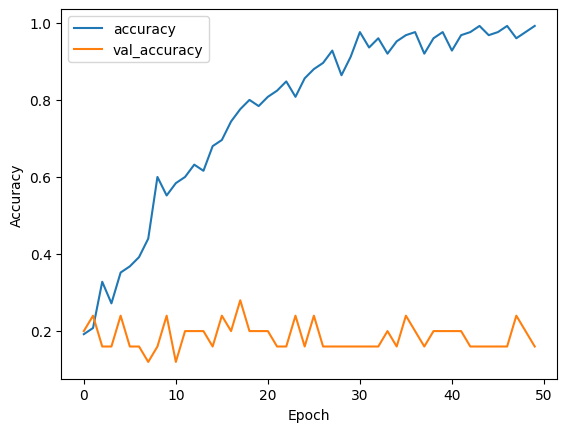

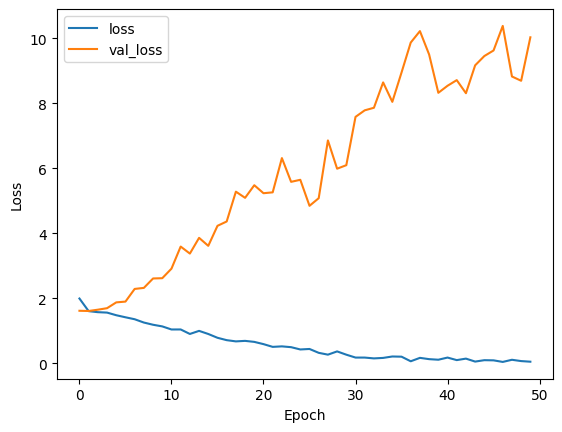

1/1 [==============================] - 2s 2s/step - loss: 10.0286 - accuracy: 0.1600
Test Accuracy: 16.00%
Test Loss: 10.028593063354492


In [9]:
import matplotlib.pyplot as plt

# Visualizar la precisión del entrenamiento y la validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar la pérdida del entrenamiento y la validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')


# **Resultados Primer modelo**

Como se puede ver en las gráficas anteriores, el modelo presenta Sobreajuste(Overfitting).  Este caso se presenta cuando el modelo se adapta demasiado a los datos de entranamiento mientras que tiene dificultades para generaliar datos nuevos, en otras palabras, el modelo esta aprendiendose de memoría el set de entrenamiento antes que aprender los patrones genericos

1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.20      0.29         5

    accuracy                           0.16        25
   macro avg       0.17      0.16      0.14        25
weighted avg       0.17      0.16      0.14        25



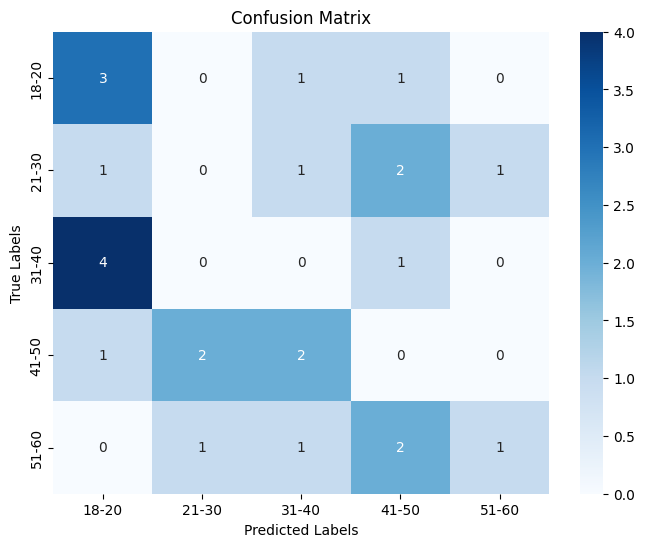

Accuracy: 0.1599999964237213


In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación del modelo en el conjunto de prueba
evaluation = model.evaluate(validation_generator)

# Obtener las etiquetas reales del conjunto de prueba
true_labels = validation_generator.classes

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(validation_generator)

# Obtener las etiquetas predichas para cada imagen
predicted_labels = np.argmax(predictions, axis=1)

# Imprimir informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Crear y visualizar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir la precisión global (accuracy)
print(f"Accuracy: {evaluation[1]}")

# **Implementación Nueva Arquitectura**

Para esta nueva implementación en busqueda de mejorar el modelo, lo primero que se hizo fue, aumentar la cantidad de imagenes que se tenía.  A diferencia del aumento pasado, en esta ocasión también se hizo modificaciones al brillo y contraste de las imagenes, el desplazamiento tanto vertical como horizontal

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=lambda img: img * 0.8 + 0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 125 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


Lo siguiente que se hizo fue incorporar algunas técnicas y capas adicionales a la arquitectura con la finalidad de evitar el sobreajuste.  En esta nueva arquitectura se implemento la Normalización por lotes (Batch Normalization) estas capas se implementaron debido a que ayudan a estabilizar y acelerar el entranmiento al normalizar la entrada de cada capa.  También se implementaron capas de Dropout, la función de estas capas es "apagar" de forma aleatoria algunas neouronas durante el entrenamiento con la finalidad de prevenir la dependencia excesiva entre las neuronas y asi reducir el sobreajuste.  Y por último se aumento el número de capas y neuronas para que asi el modelo pudiera aprender repsentaciones más complejas de los datos.

In [83]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = models.Sequential()

# Capas convolucionales y de agrupación
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.31))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.31))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.31))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.31))

# Aplanar antes de la capa densa
model.add(layers.Flatten())

# Capas densas con regularización L2
model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(5, activation='softmax'))  # 5 clases para los grupos de edades

# Compilar el modelo
model.compile(Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_107 (MaxPool  (None, 111, 111, 32)      0         
 ing2D)                                                          
                                                                 
 batch_normalization_156 (B  (None, 111, 111, 32)      128       
 atchNormalization)                                              
                                                                 
 dropout_136 (Dropout)       (None, 111, 111, 32)      0         
                                                                 
 conv2d_108 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_108 (MaxPool  (None, 54, 54, 64)      

Por úlitmo se redujeron las epocas de entramiento con la finalidad de evitar esta "memorización" de patrones por parte del modelo. Y se hace uso de Early Stopping para monitorear la pérdida del conjunto de validación.  Esto hará que se detenga el entrenamiento si no se observa alguna mejora despues de 5 epocas.

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir la callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,  # Puedes ajustar este número según sea necesario
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/30
4/4 [==============================] - 19s 4s/step - loss: 3.2569 - accuracy: 0.1440 - val_loss: 2.2866 - val_accuracy: 0.3200
Epoch 2/30
4/4 [==============================] - 13s 3s/step - loss: 2.9662 - accuracy: 0.2560 - val_loss: 2.2930 - val_accuracy: 0.2000
Epoch 3/30
4/4 [==============================] - 13s 4s/step - loss: 2.9901 - accuracy: 0.2720 - val_loss: 2.3066 - val_accuracy: 0.2000
Epoch 4/30
4/4 [==============================] - 13s 3s/step - loss: 2.7015 - accuracy: 0.2720 - val_loss: 2.3236 - val_accuracy: 0.2000
Epoch 5/30
4/4 [==============================] - 13s 3s/step - loss: 2.7935 - accuracy: 0.2960 - val_loss: 2.3340 - val_accuracy: 0.2000
Epoch 6/30
4/4 [==============================] - 14s 4s/step - loss: 2.7704 - accuracy: 0.2720 - val_loss: 2.3555 - val_accuracy: 0.2000


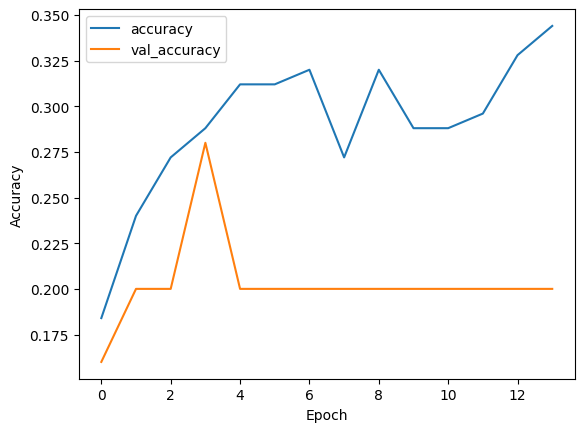

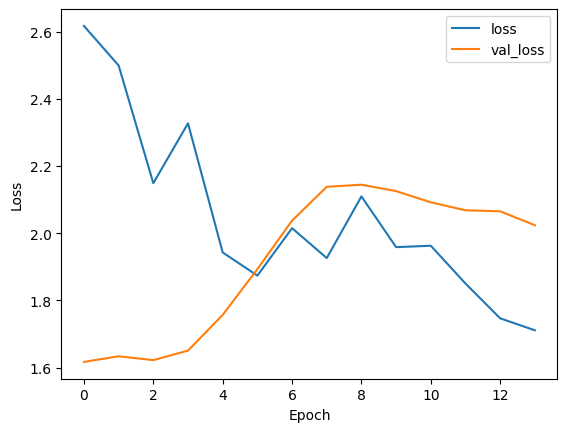

1/1 [==============================] - 2s 2s/step - loss: 1.6509 - accuracy: 0.2800
Test Accuracy: 28.00%
Test Loss: 1.650883436203003


In [54]:
import matplotlib.pyplot as plt

# Visualizar la precisión del entrenamiento y la validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar la pérdida del entrenamiento y la validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')

# **Resultados Segundo Intento**

Si bien en las gráficas mostradas anteriormente se puede observar que le modelo sigue teniendo OverFitting debido a que el accurency del entramiento aumenta, el accurrency del conjunto de validación no pasa lo mismo.  Por otra parte las perdidas de ambos conjuntos no siguen la misma tendencia

1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.18      0.80      0.30         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5

    accuracy                           0.16        25
   macro avg       0.04      0.16      0.06        25
weighted avg       0.04      0.16      0.06        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


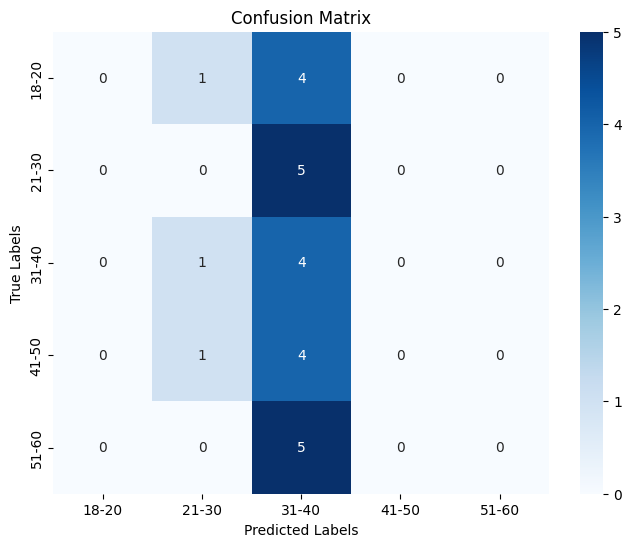

Accuracy: 0.2800000011920929


In [56]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación del modelo en el conjunto de prueba
evaluation = model.evaluate(validation_generator)

# Obtener las etiquetas reales del conjunto de prueba
true_labels = validation_generator.classes

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(validation_generator)

# Obtener las etiquetas predichas para cada imagen
predicted_labels = np.argmax(predictions, axis=1)

# Imprimir informe de clasificación
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Crear y visualizar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir la precisión global (accuracy)
print(f"Accuracy: {evaluation[1]}")

